In [1]:
library('tidymodels')

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [2]:
data_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-11-23/episodes.csv"

dr_who_raw = readr::read_csv(data_url, col_types = readr::cols())

dr_who_raw |> head()

era,season_number,serial_title,story_number,episode_number,episode_title,type,first_aired,production_code,uk_viewers,rating,duration
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>
revived,1,NA,157,1,Rose,episode,2005-03-26,1.1,10.81,76,45
revived,1,NA,158,2,The End of the World,episode,2005-04-02,1.2,7.97,76,44
revived,1,NA,159,3,The Unquiet Dead,episode,2005-04-09,1.3,8.86,80,44
revived,1,NA,160a,4,Aliens of London,episode,2005-04-16,1.4,7.63,82,45
revived,1,NA,160b,5,World War Three,episode,2005-04-23,1.5,7.98,81,42
revived,1,NA,161,6,Dalek,episode,2005-04-30,1.6,8.63,84,45


Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`)."


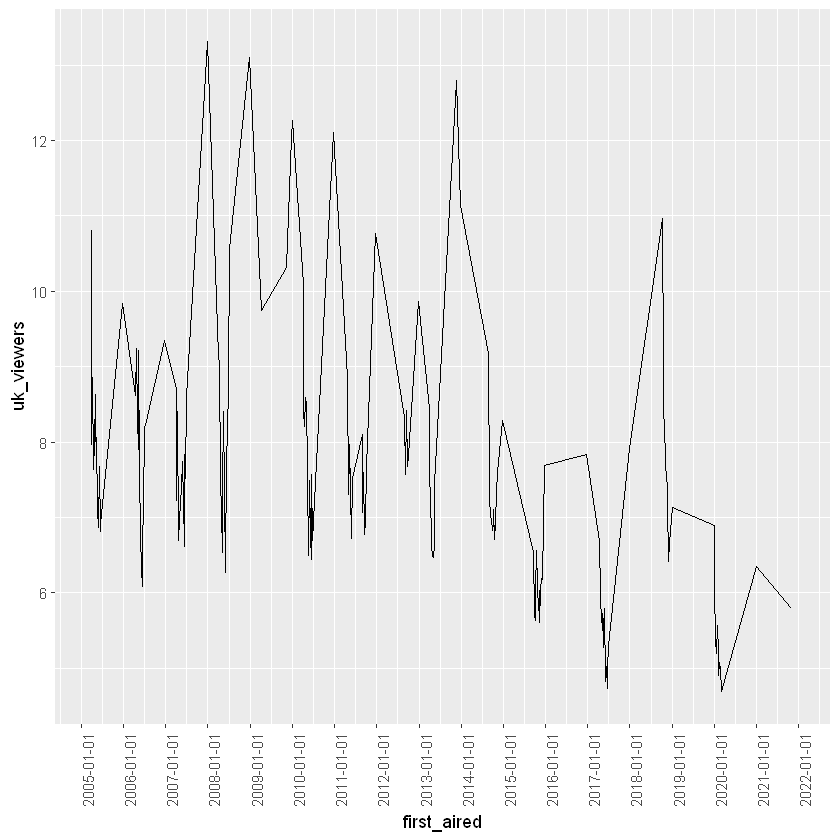

In [3]:
ggplot(dr_who_raw, aes(x = first_aired, y = uk_viewers)) + 
    geom_line() +
    scale_x_date(breaks = '1 year') + 
    theme(axis.text.x = element_text(angle = 90))

In [4]:
mod = linear_reg() |> set_engine('lm')

rec = recipe(uk_viewers ~ first_aired, data = dr_who_raw) |>
    step_naomit(uk_viewers) |>
    step_date(first_aired, features = 'year') |>
    step_holiday(first_aired, holidays = c('NewYearsDay', 'ChristmasDay'), keep_original_cols = FALSE) |>
    prep()

rec |> juice() |> head()

uk_viewers,first_aired_year,first_aired_NewYearsDay,first_aired_ChristmasDay
<dbl>,<int>,<int>,<int>
10.81,2005,0,0
7.97,2005,0,0
8.86,2005,0,0
7.63,2005,0,0
7.98,2005,0,0
8.63,2005,0,0


In [5]:
mod_fit = mod |> fit(uk_viewers ~ ., data = rec |> juice())

tidy(mod_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),332.8192244,42.41269988,7.847160,5.324955e-13
first_aired_year,-0.1618328,0.02108407,-7.675593,1.429813e-12
first_aired_NewYearsDay,1.8383588,0.63850344,2.879168,4.522717e-03
first_aired_ChristmasDay,2.8764459,0.35760113,8.043727,1.698128e-13


In [6]:
boots = bootstraps(dr_who_raw, times = 1000, apparent = TRUE)

boots |> glimpse()

Rows: 1,001
Columns: 2
$ splits <list> [<boot_split[172 x 60 x 172 x 12]>], [<boot_split[172 x 60 x 1…
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…


In [7]:
boot_models = boots |>
    mutate(model = map(splits, ~mod |> fit(uk_viewers ~ ., data = bake(rec, new_data = .x))))

boot_models |> glimpse()

Rows: 1,001
Columns: 3
$ splits <list> [<boot_split[172 x 60 x 172 x 12]>], [<boot_split[172 x 60 x 1…
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…
$ model  <list> [NULL, ~NULL, ~NULL, regression, FALSE, stats, formula, formul…


In [9]:
coef_df = boot_models |>
    mutate(coef_info = map(model, tidy)) |>
    select(-splits, -model) |>
    unnest(coef_info)

coef_df |> head()

id,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Bootstrap0001,(Intercept),326.7033128,41.38246733,7.894728,4.042689e-13
Bootstrap0001,first_aired_year,-0.1588055,0.02057134,-7.719747,1.109875e-12
Bootstrap0001,first_aired_NewYearsDay,3.1889525,0.55496892,5.746182,4.373793e-08
Bootstrap0001,first_aired_ChristmasDay,2.5711834,0.35176916,7.309292,1.139930e-11
Bootstrap0002,(Intercept),330.2892048,42.90679724,7.697829,1.258673e-12
Bootstrap0002,first_aired_year,-0.1605973,0.02132944,-7.529372,3.292913e-12


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 14 rows containing non-finite outside the scale range (`stat_bin()`)."


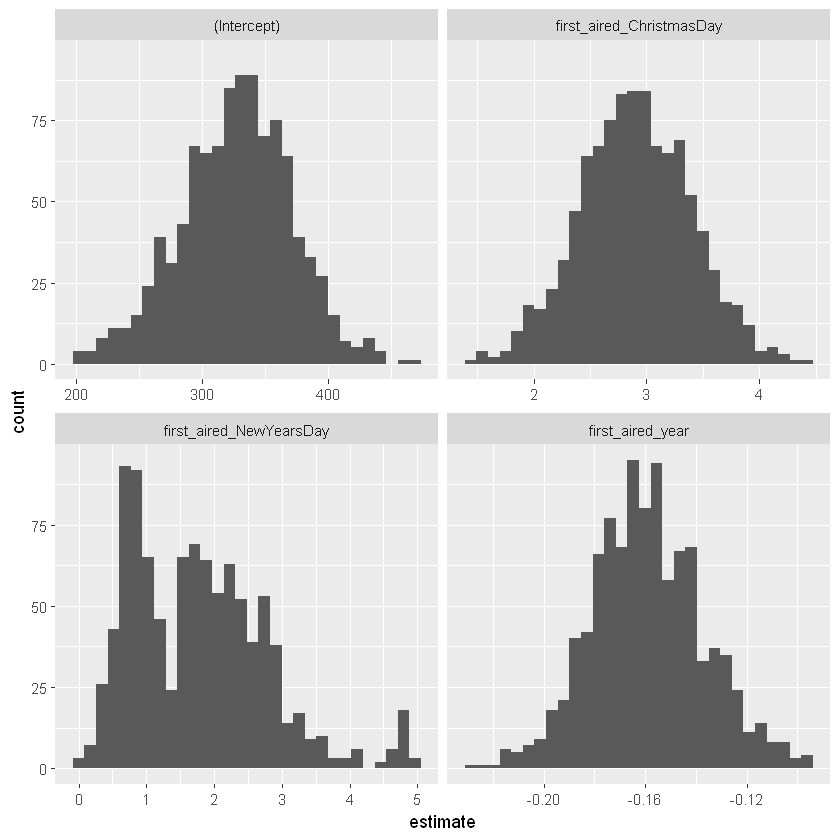

In [10]:
ggplot(coef_df, aes(x = estimate)) + 
    geom_histogram() +
    facet_wrap(~term, scales = 'free_x')
    

In [11]:
coef_df |>
    group_by(term) |>
    summarize(lower_ci = quantile(estimate, 0.025, na.rm = T), upper_ci = quantile(estimate, 0.975, na.rm = T))

term,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
(Intercept),234.1239838,409.4574721
first_aired_ChristmasDay,1.9440057,3.8681993
first_aired_NewYearsDay,0.3605998,4.6163437
first_aired_year,-0.1999995,-0.1127073
